In [5]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq


EPOINT = 0
np.seterr(invalid='ignore')
plt.rcParams.update({'font.size': 20})
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

# A collection of functions

In [6]:
'''
Getting the number of KIC's that we'll be evaluating, used to initialize the np.array to the right size.
'''
def getSize(file):
    temp = pd.read_table(file, names=['kic'])
    getsize = temp['kic'].values
    return getsize.size



'''
Standard Chi-Sqaured Calculation.
'''
def calcChiSq(data, fit, errList):
    chiSq = np.sum(((data - fit) / errList)**2.0)/np.size(data)
    return chiSq



'''
Calculating the asymmetric error bars.
'''
def calcError(data, multiple):
    data = data*multiple
    errDn = (np.abs(data * (1.-1./(9. * data)-1./(3.*np.sqrt(data)))**3.-data))/multiple
    errUp = (np.sqrt(data + 0.75) + 1.0)/multiple
    return errUp, errDn



'''
Getting the Bayesian Information Criterion value, which is used to rank the 'goodness' of a fit, preventing 
overfitting of the data.
'''
def calcBic(size, degree, chiSq):
    bic = chiSq + ((degree+1) * np.log(size))
    return bic
    
  

'''
Fitting a degree K polynomial to the data, getting the error of that fit from the covariance matrix.
'''    
def fitDegreeK(xaxis, yaxis, errList, degree, size):
    if(degree == 0):
        parameters = [np.mean(yaxis)]
        covariance = np.array([[np.std(yaxis)**2,0],[0,0]])
    else:
        parameters, covariance = np.polyfit(xaxis, yaxis, degree, cov=True, full =False)
    
    fit = np.polyval(parameters, xaxis)
    chiSq = calcChiSq(yaxis, fit, errList)
    bic = calcBic(size, degree, chiSq)
    return bic, fit, parameters, covariance, chiSq



'''
Updating the array that will become the text file with our fit parameters
'''
def updateArray(exportArray, targetIndex, KIC, size, degree, bestParameters, bestChiSquare, bestCov):
    exportArray[targetIndex, 0] = KIC
    exportArray[targetIndex, 1] = size
    exportArray[targetIndex,2] = degree
    exportArray[targetIndex, 3] = '{}'.format('%.4f'%bestChiSquare)
    length = len(bestParameters)
    
    for y in range(length):
        exportArray[targetIndex, (8-length+y)] = '{}'.format('%.4f'%bestParameters[y])
        exportArray[targetIndex, (12-length+y)] = '{}'.format('%.4f'%(np.sqrt(bestCov[y,y]))) 
    return exportArray



'''
Plotting energy VS frequency. Will plot the entirety of the data unless whole==False, which will cause it to plot
only the data above the [ok68i] cutoff, which can be considered the 'significant' data
'''
def plotEVF(KIC, files, fileCount, **kwargs):
    plt.figure(figsize=(9,7))
    plt.title("FFD_X vs FFD_Y ("+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Flare Energy (erg)")
    plt.yscale('log') 
    errListUp = np.array([])
    errListDn = np.array([])
    
    for k in range(fileCount):
        toteDuration = pd.read_table(files[k], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] #getting the total duration of each file
        df = pd.read_table(files[k], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array
        ffdXEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffdYFrequency = (np.arange(1, len(ffdXEnergy)+1, 1))/toteDuration #get evenly spaced intervals, divide by totedur to get flares/day
        
        if(kwargs['whole']==True):  #plotting all data
            plt.plot(ffdXEnergy, ffdYFrequency, lw = 1, c = cmap(k/float(fileCount)))
            
            if(kwargs['error']==True):
                errUp, errDn = calcError(ffdYFrequency, toteDuration)
                plt.errorbar(ffdXEnergy, ffdYFrequency, yerr = [errDn, errUp], c = 'black', elinewidth=.3, fmt='o', markersize = .55)            
        
        else: #use ED68i to get indices of useful data, ignore the junk
            ok68 = ffdXEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT
            plt.plot(ffdXEnergy[ok68], ffdYFrequency[ok68], lw = 1, c = cmap(k/float(len(files))))
            
            if(kwargs['error']==True):
                errUp, errDn = calcError(ffdYFrequency[ok68], toteDuration)
                plt.errorbar(ffdXEnergy[ok68], ffdYFrequency[ok68], yerr = [errDn, errUp], c = 'black', elinewidth=.3, fmt='o', markersize = .55)
        
    #plt.savefig('energy_vs_frequency_plot/'+KIC+'_whole_FFD.png')
    if(kwargs['show']==True):
        plt.show()
        #wait = input("Press enter to continue")
        #plt.close()
    
    
    
'''
Plotting time VS frequency. Determining which fit is best, then exporting the best fit and all previous fit data
to a file
'''    
def plotTVF(KIC, files, fileCount, exportArray, fixedEnergy, targetIndex, **kwargs):
    plt.figure(figsize=(9,7))
    plt.title("Time vs Frequency (KIC "+KIC+', E = '+str(fixedEnergy)+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Time (days)")
    plt.yscale('log')
    plt.ylim([0.001,10])
    plt.xlim([0,1800]) 

    xaxis = np.array([])
    yaxis = np.array([])
    errListUp = np.array([])
    errListDn = np.array([])
    
    for x in range(fileCount):
        toteDuration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] #getting the total duration of each file
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array
        ffdXEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy        
        ffdYFrequency = (np.arange(1, len(ffdXEnergy)+1, 1))/toteDuration #get evenly spaced intervals, divide by totedur to get flares/day

        if(np.amax(ffdXEnergy) >= fixedEnergy >= np.amin(ffdXEnergy)): #checking that the energy constant isn't out of bound,otherwise, interpolate doesn't work
            ok68 = ffdXEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk
            meanStart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file

            if any(ok68): #checking if ok68 contains at least one 'true'
                ffdYAtEnergy = np.interp(fixedEnergy, ffdXEnergy[ok68][::-1], ffdYFrequency[ok68][::-1])#interpolating the ffd_y
                xaxis = np.append(xaxis, meanStart) #making lists so we can fit a line later
                yaxis = np.append(yaxis, ffdYAtEnergy)

                errUp, errDn = calcError(ffdYAtEnergy, toteDuration)#dealing w/ error
                errListUp = np.append(errListUp, errUp) 
                errListDn = np.append(errListDn, errDn)
                
    bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size = compareFits(xaxis, yaxis, errListUp)

    exportArray = updateArray(exportArray, targetIndex, KIC, size, bestFitDegree, bestParameters, bestChiSquare, bestCovariance)
    plt.plot(xaxis, bestFit, 'red', lw=1)
    plt.errorbar(xaxis, yaxis, yerr = [errListDn,errListUp], fmt='o', color= 'black',markersize=4, elinewidth=1,capsize=6)#plotting error
    plt.annotate('Degree Of Fit = {}\nChi-Square = {}'.format(bestFitDegree, '%.3f'%(bestChiSquare)), xy=(1750, 7),size=16, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
    #plt.savefig('time_vs_frequency_plot/'+KIC+'_vs_time_E='+str(fixedEnergy)+'.png')        
    if(kwargs['show']==True):
        plt.show()
        #wait = input("Press enter to continue")
        #plt.close()
        
 

'''
Fitting a horizontal line to the data, then using the BIC evaluation to see if a degree+=1 polynomial 
would be a better fit. Continuing until the BIC calculation says stop or degree reaches 4, which is extremely unlikely
'''
def compareFits(xaxis, yaxis, errList):
        size = np.size(xaxis)
        bestFitDegree = 0
        bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = fitDegreeK(xaxis, yaxis, errList, bestFitDegree, size)
        degree = 1
        
        while(degree<4):
            try:
                bic2, fit, parameters, covariance, chiSquare = fitDegreeK(xaxis, yaxis, errList, degree, size)
            except:
                break
            if ((bic1 - bic2) >=2):
                bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = bic2, fit, parameters, covariance, chiSquare
                bestFitDegree = degree
                degree+=1
            else:
                break
                
        return bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size

# Plotting energy_vs_frequency for each KIC and time_vs_energy for each KIC/energy combination

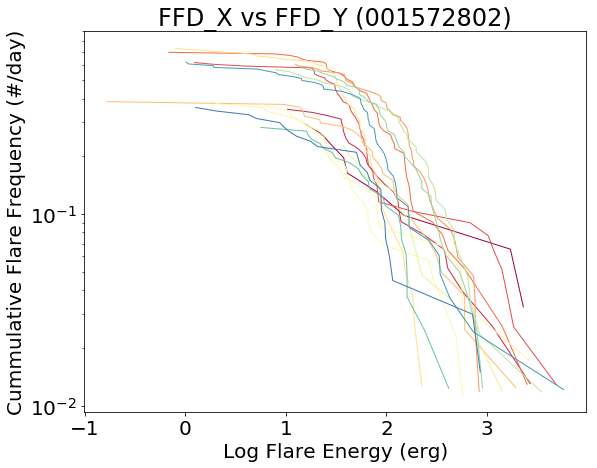

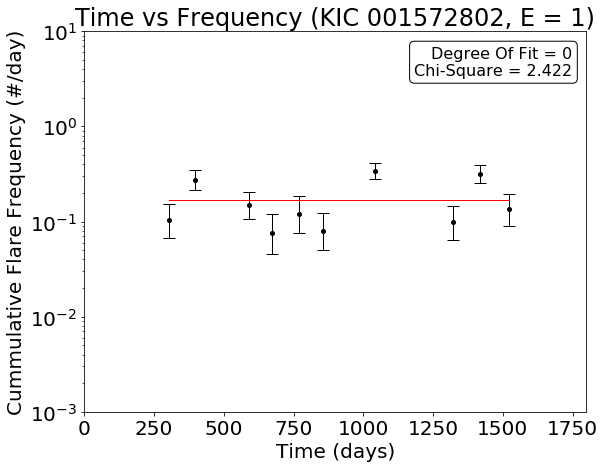

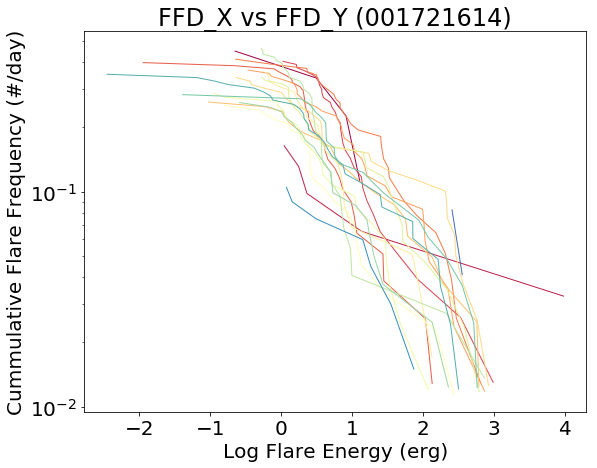

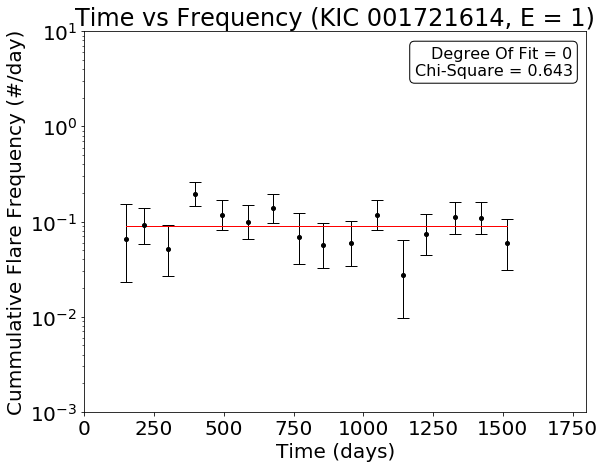

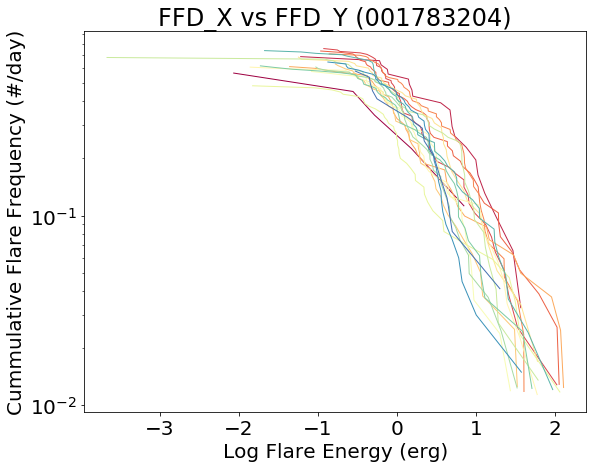

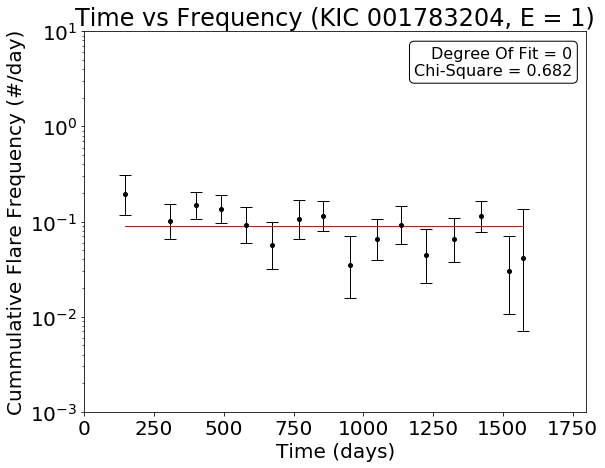

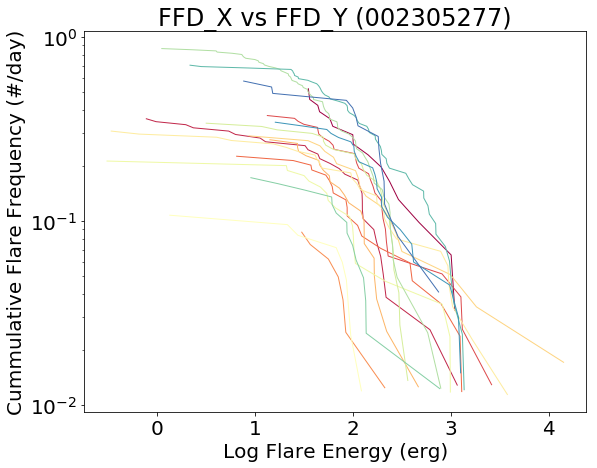

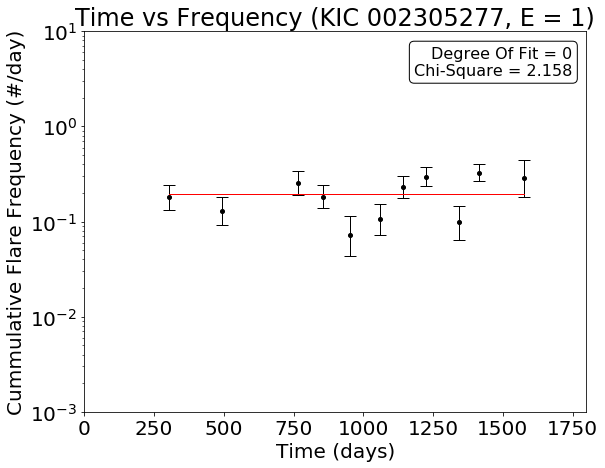

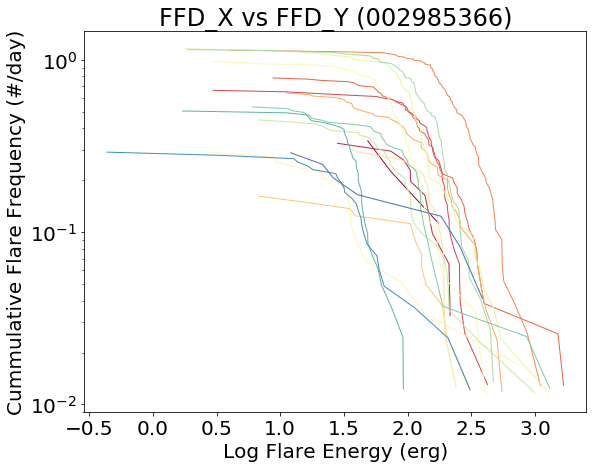

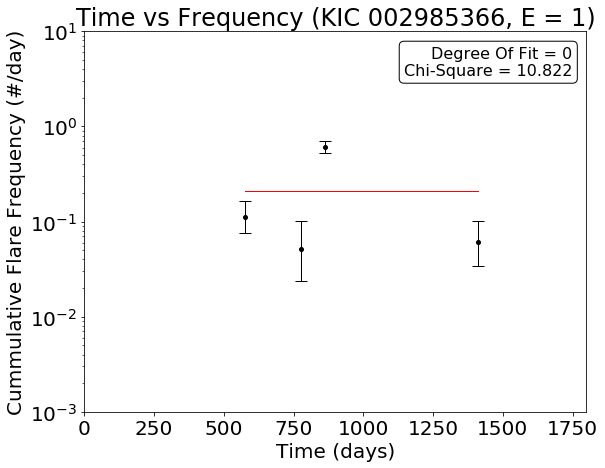

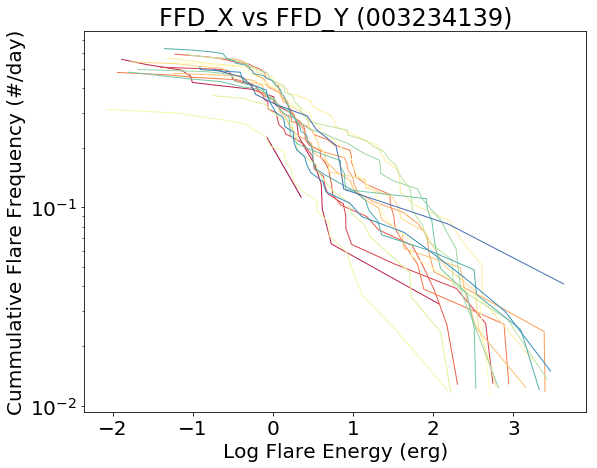

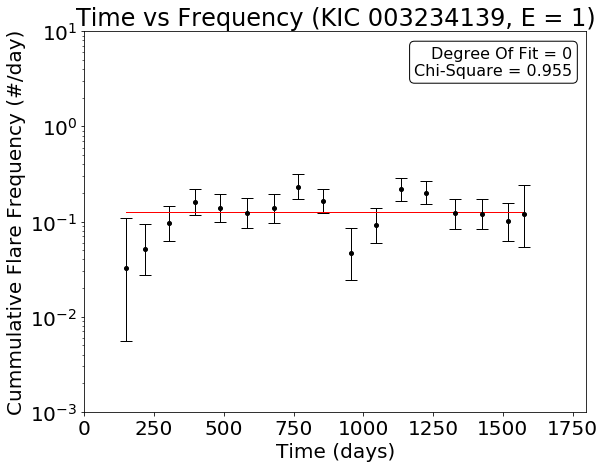

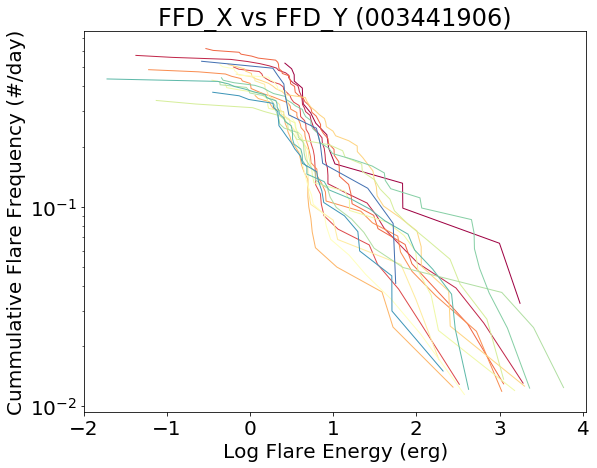

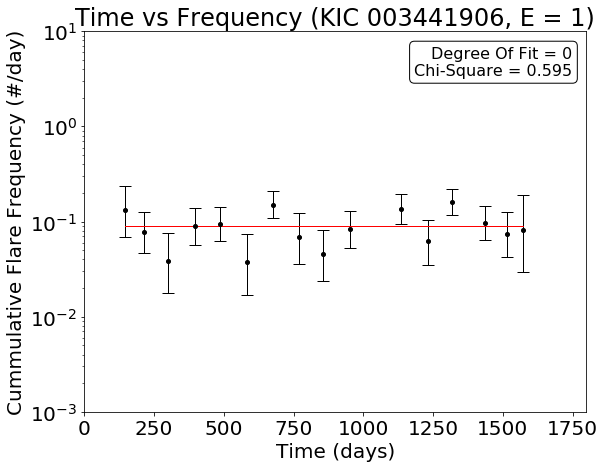

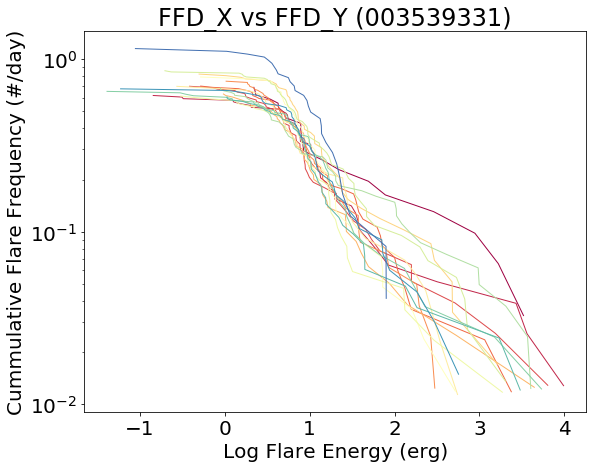

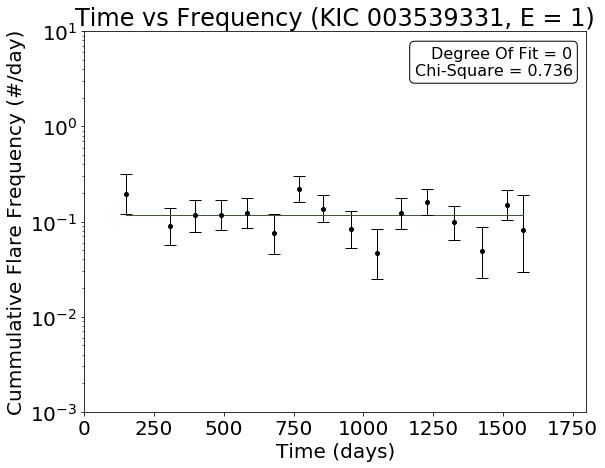

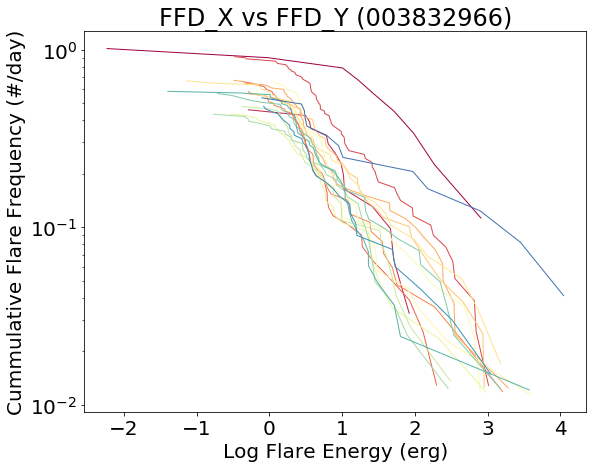

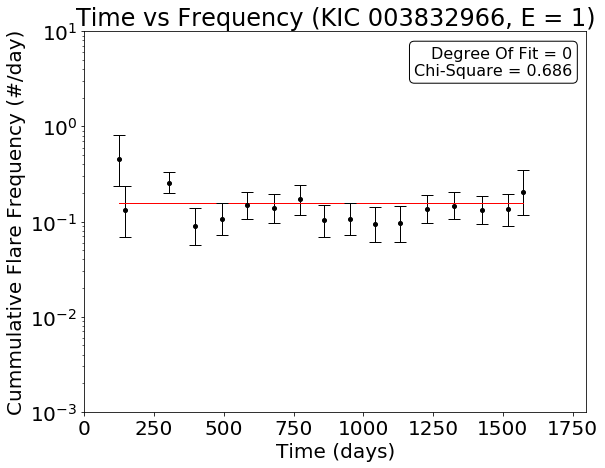

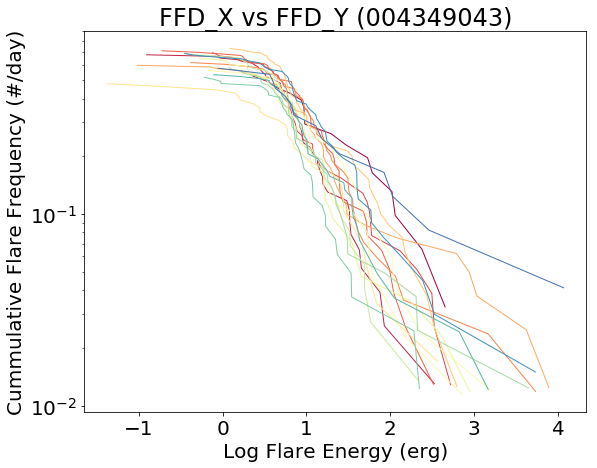

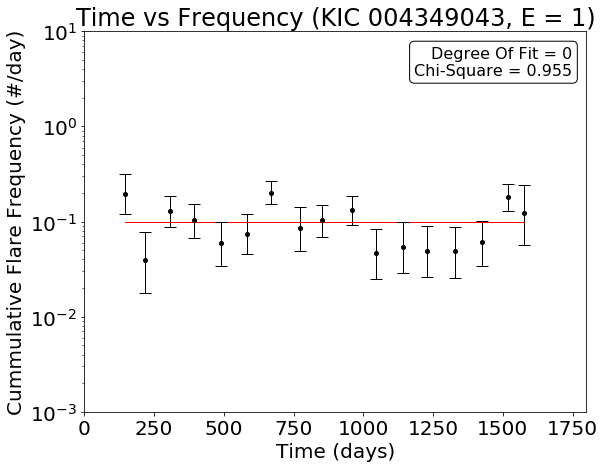

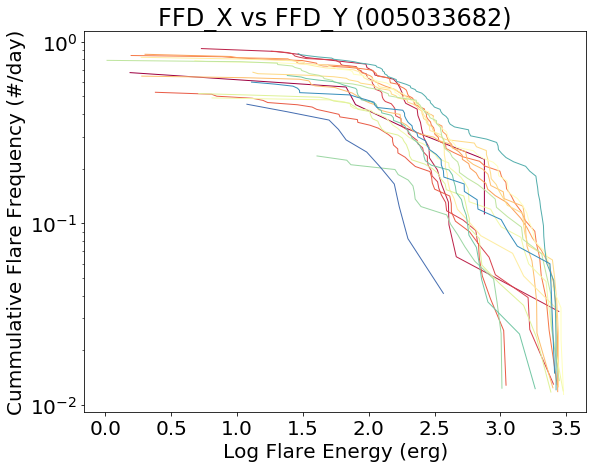

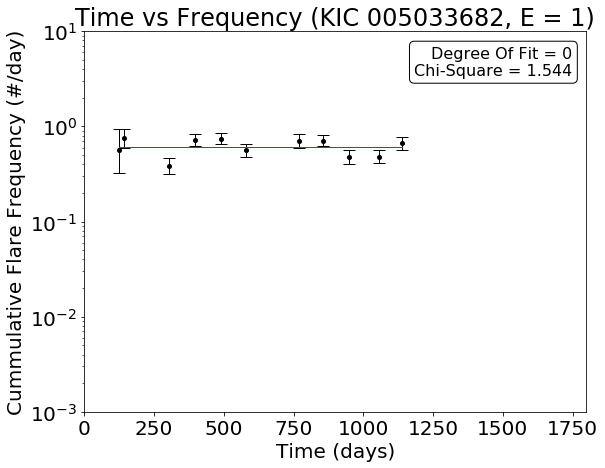

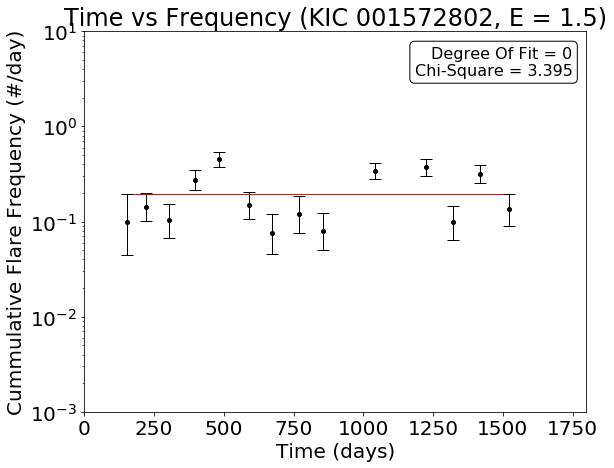

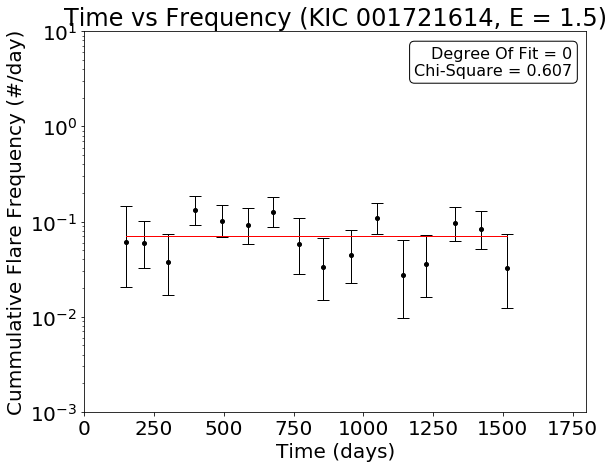

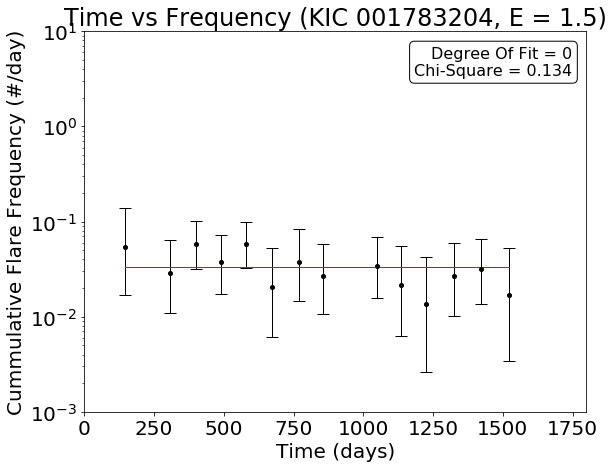

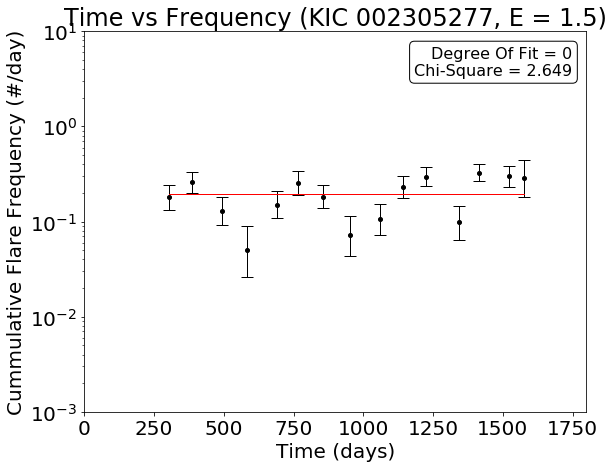

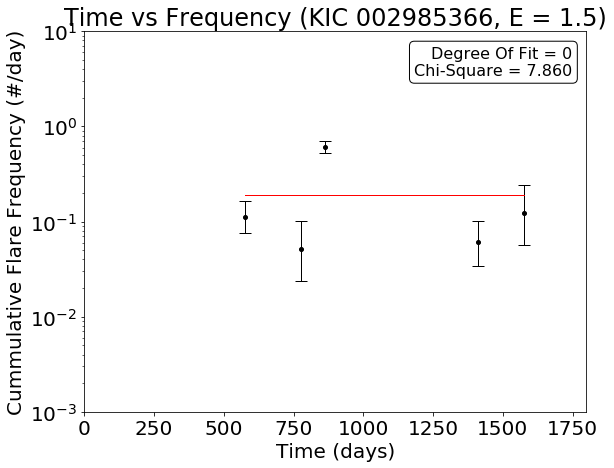

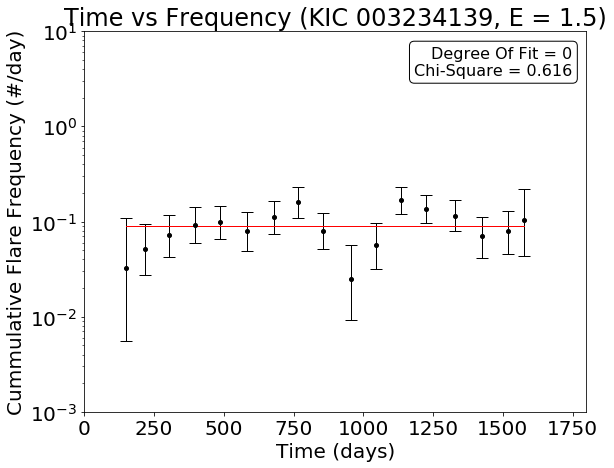

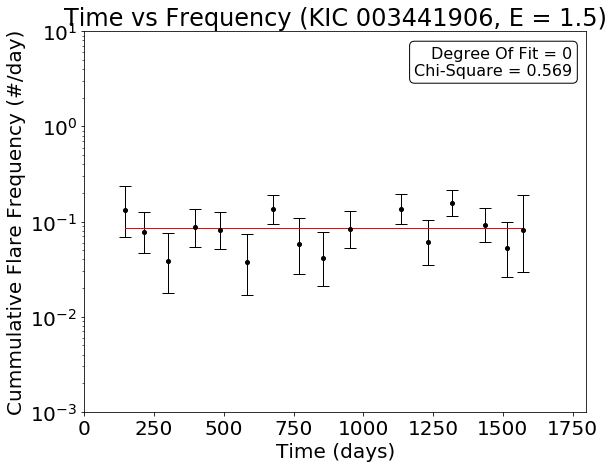

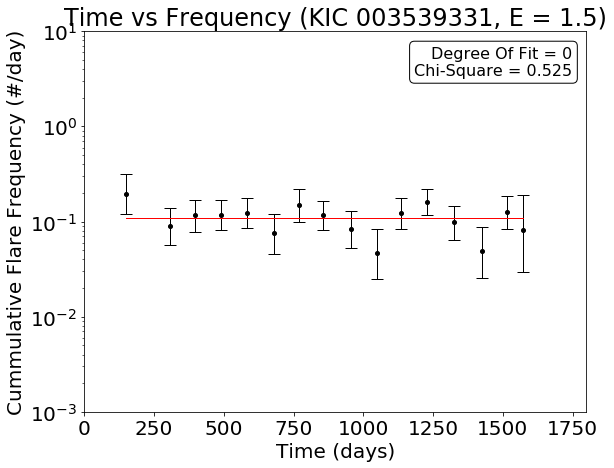

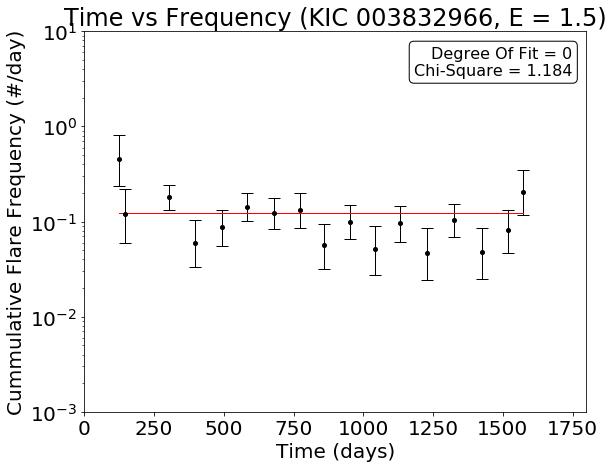

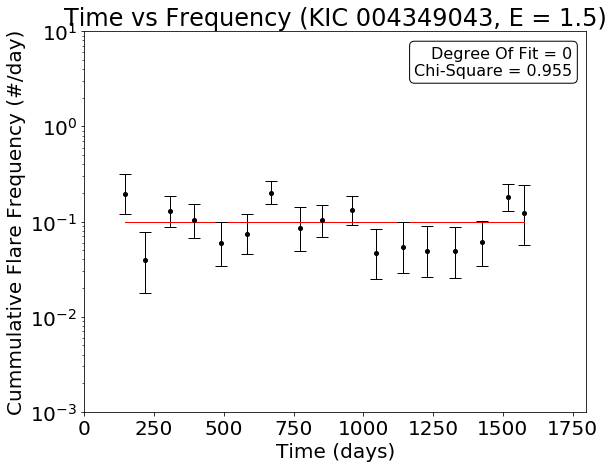

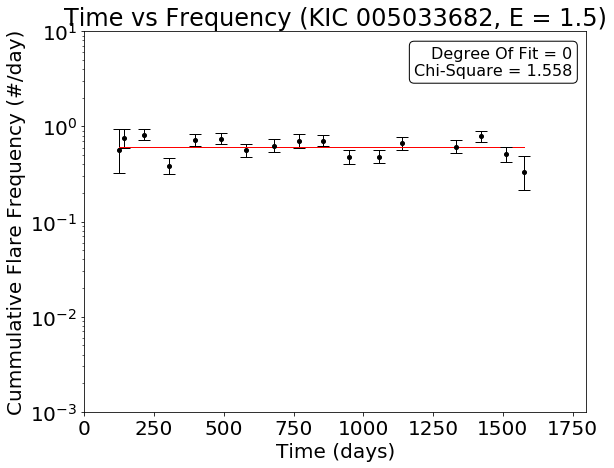

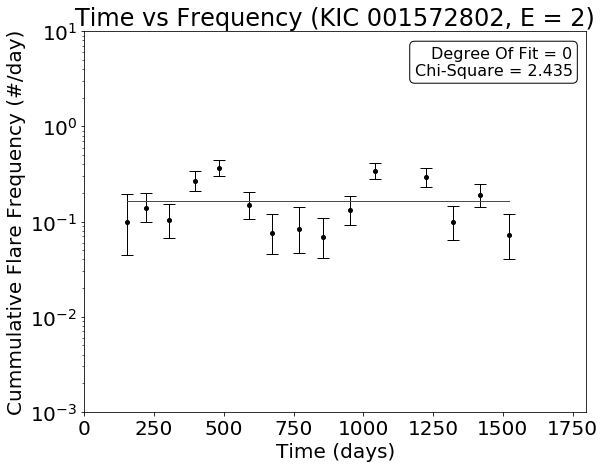

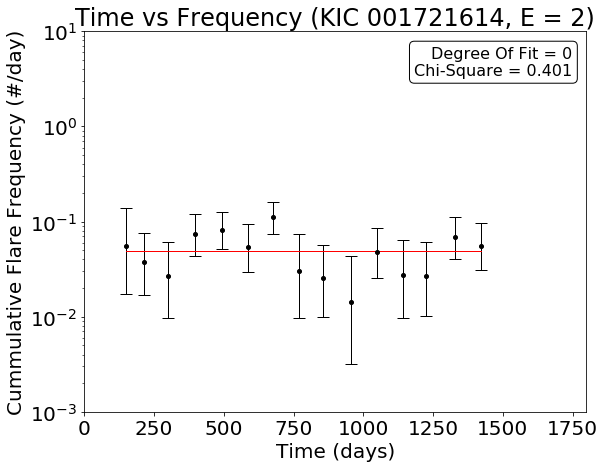

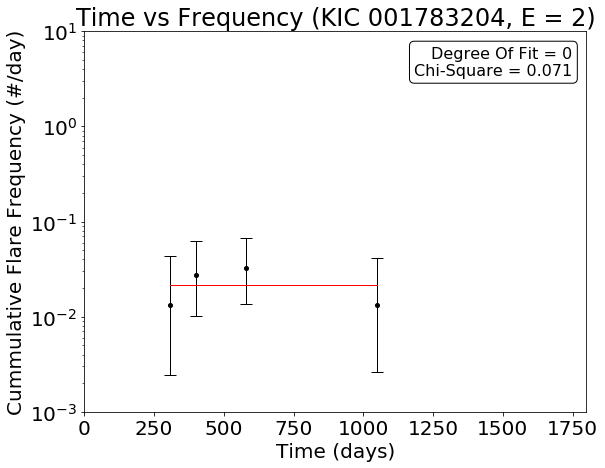

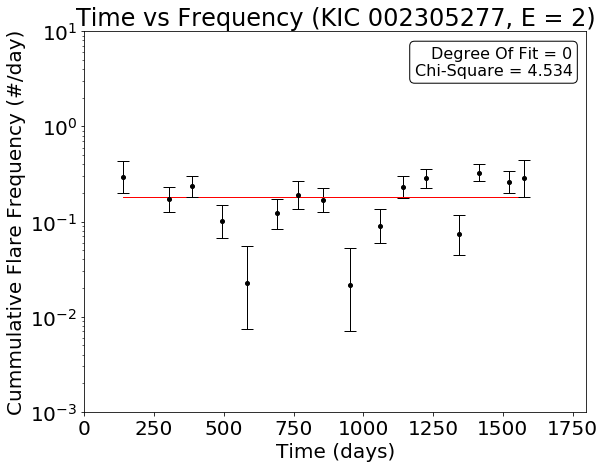

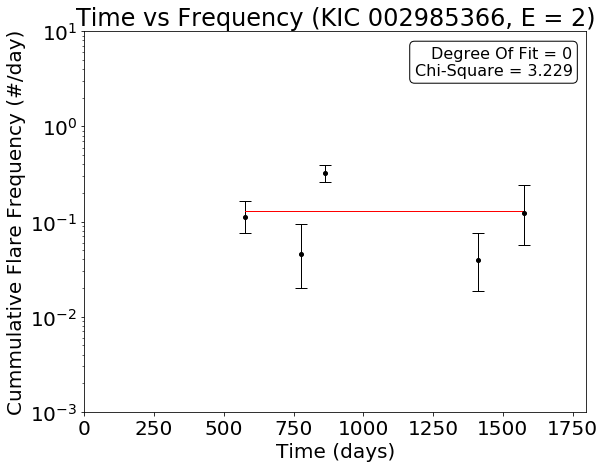

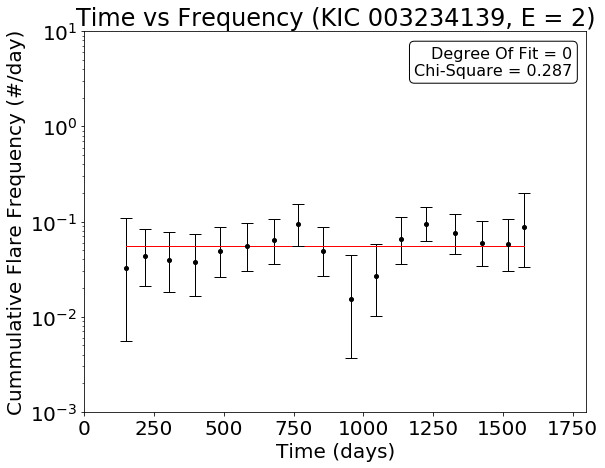

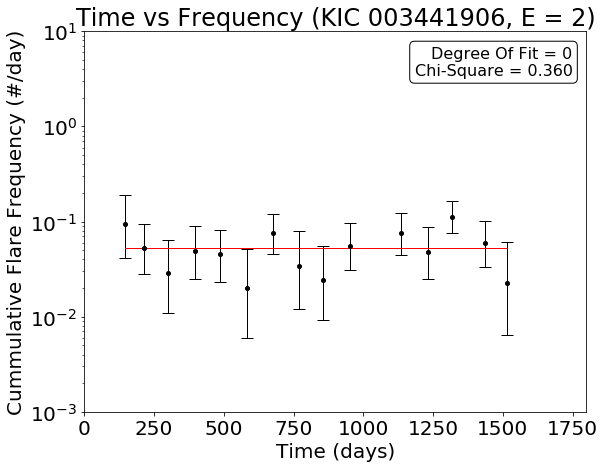

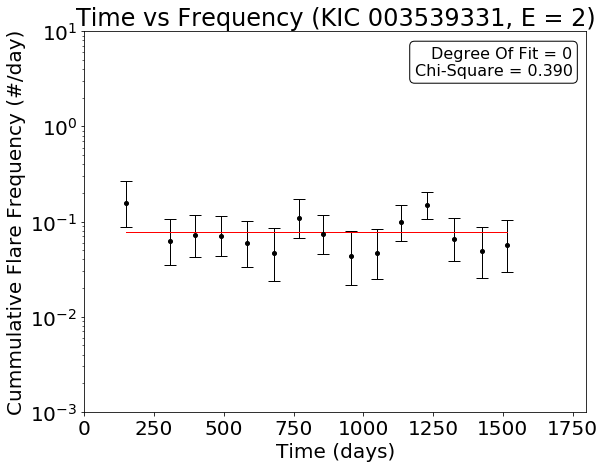

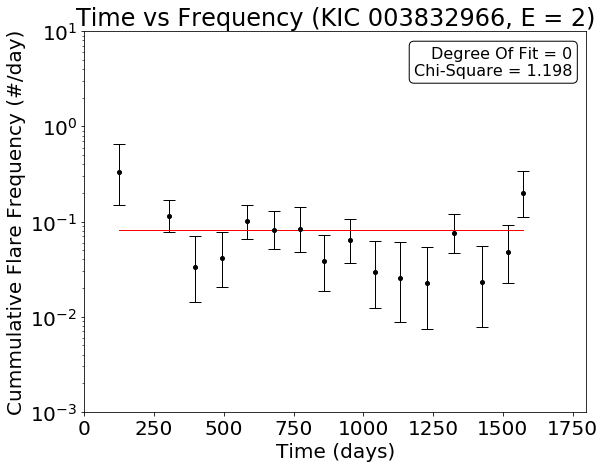

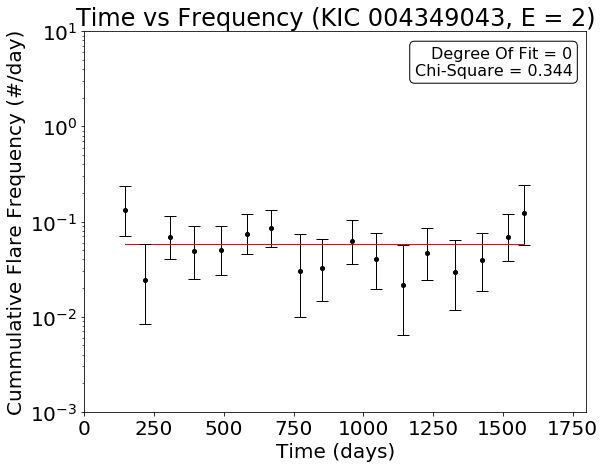

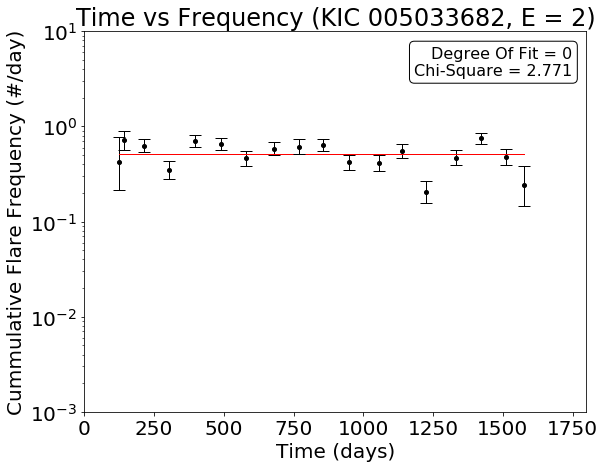

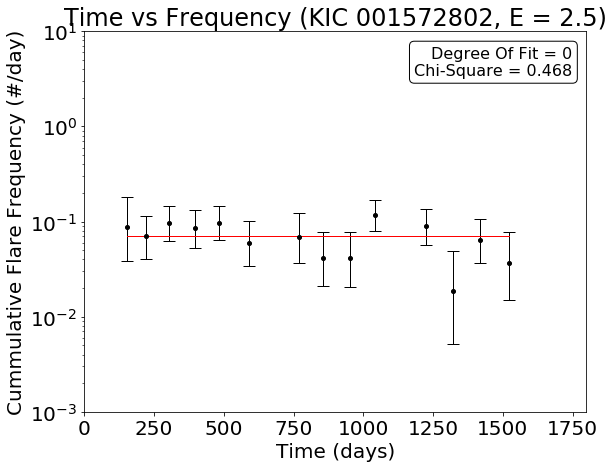

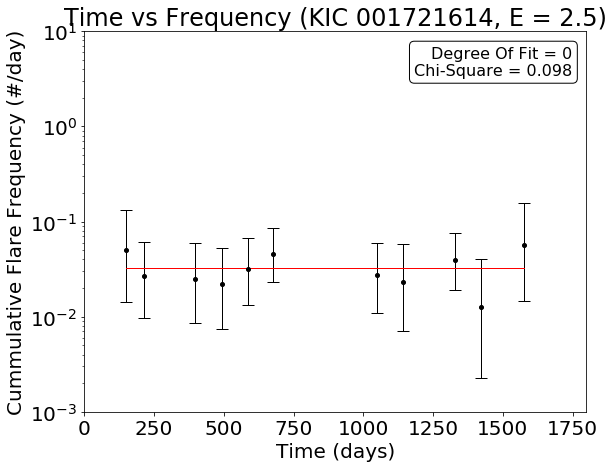

/Users/scoggim/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scoggim/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/scoggim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


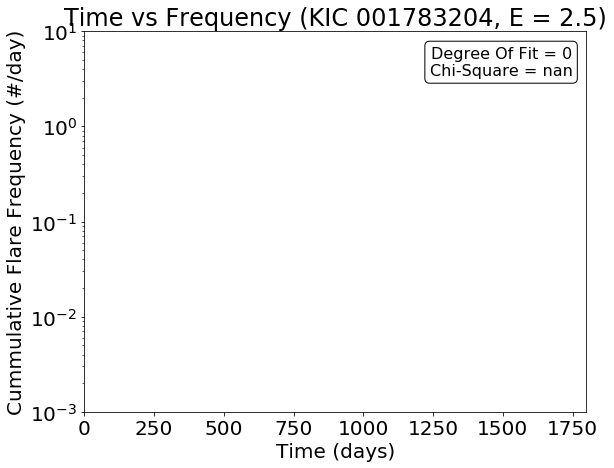

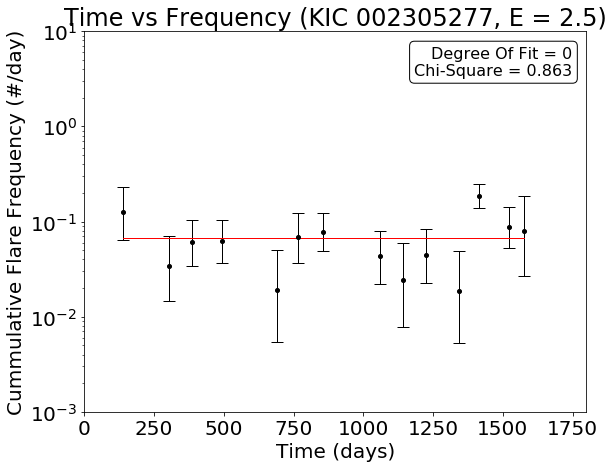

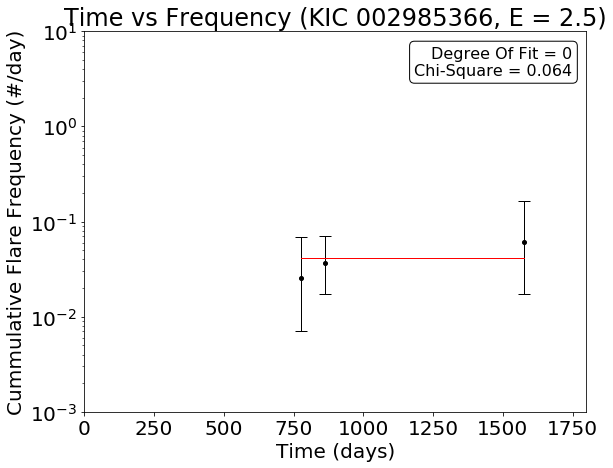

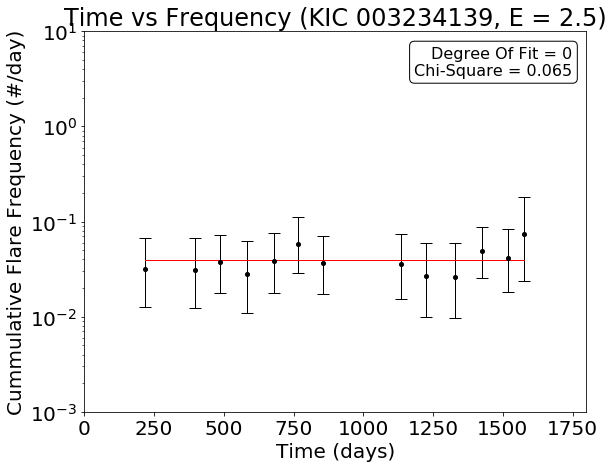

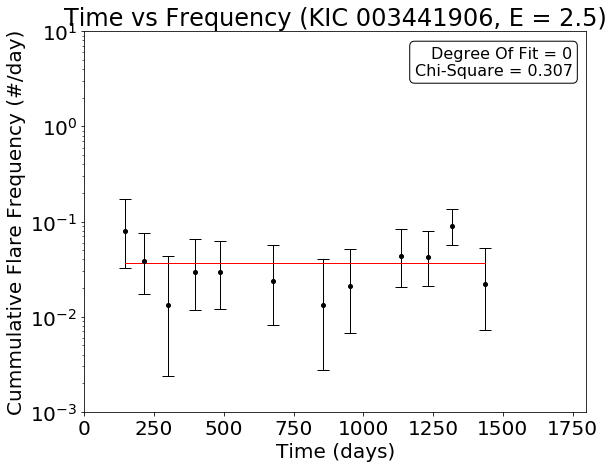

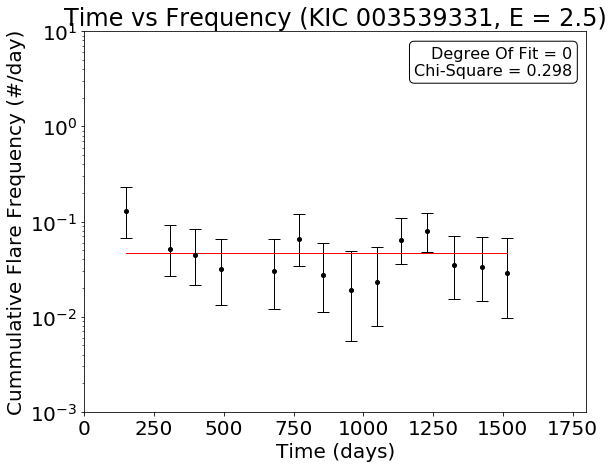

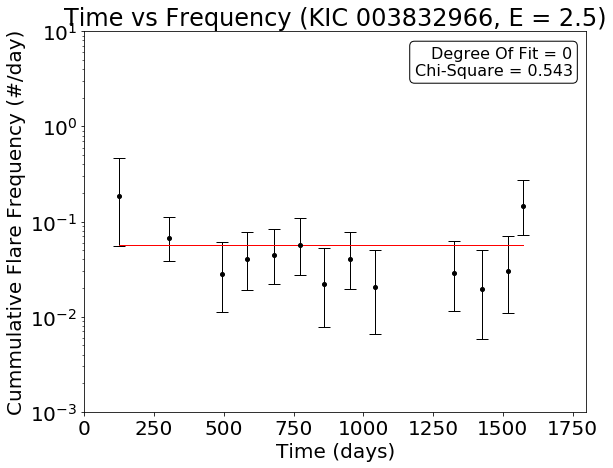

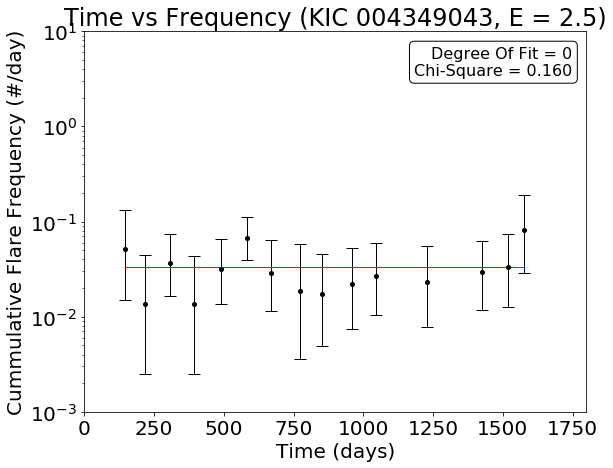

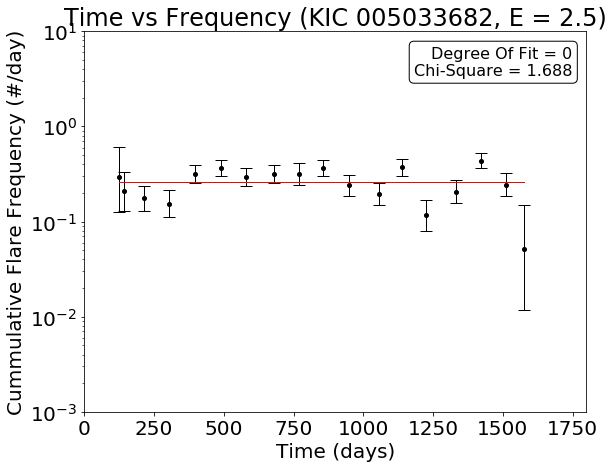

In [7]:
targetCount = getSize('KICs/targets.txt') #getting the number of targets using the target file
energyConstantList = [1, 1.5, 2, 2.5] #a list containing all of the energies we'll plot TVF at
evfDir = 'energy_vs_frequency_plot'
tvfDir = 'time_vs_frequency_plot'
fitData = 'fit_data'

if not os.path.exists(evfDir): #searching for, and making the directories if they don't exist
    os.makedirs(evfDir)
if not os.path.exists(tvfDir):
    os.makedirs(tvfDir)
if not os.path.exists(fitData):
    os.makedirs(fitData)
    
for energyConstant in energyConstantList:
    
    targets = open('KICs/targets.txt', "r") # a file containing all the KICs we want to plot  
    fixedEnergy = energyConstant + EPOINT # the fixed energy value
    exportArray = np.zeros((targetCount + 2, 12), dtype='O') #what will become the data file containing all of our fit information
    exportArray[0] = ["#This is a file containing the parameters and errors involved in the best fit of a KIC's time vs frequency data",'','','','','','','','','','',''] 
    exportArray[1] = ["#KIC", 'N', 'best degree', 'chiSquare', 'X^3', 'X^2', 'X^1', 'X^0', 'Error3', 'Error2', 'Error1', 'Error0']
    targetIndex = 2
    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICS/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
        fileCount = len(files) 
        
        if(energyConstant == energyConstantList[0]):
            plotEVF(KIC, files, fileCount, error=False, show=True, whole=True) 
        
        plotTVF(KIC, files, fileCount, exportArray, fixedEnergy, targetIndex, show=True)
        targetIndex += 1
        
    #np.savetxt('fit_data/fit_data_for_E='+str(fixedEnergy)+'.txt', exportArray, fmt = '% 15s', delimiter=' ', newline='\n', header='', footer='', comments='# ')
    targets.close()   

# Plotting energy_vs_frequency

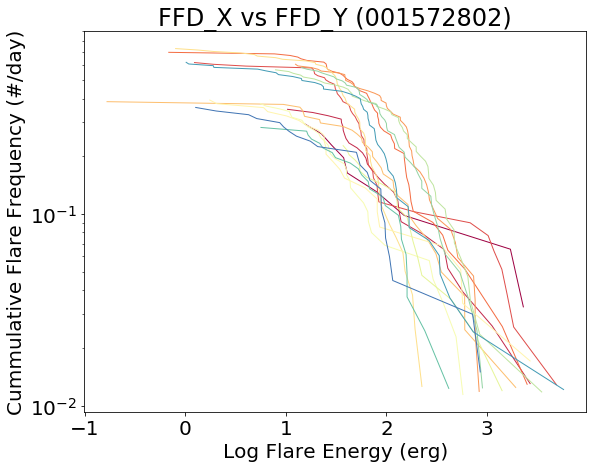

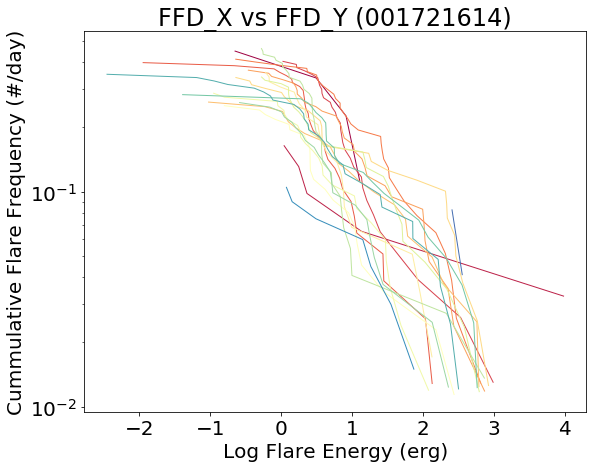

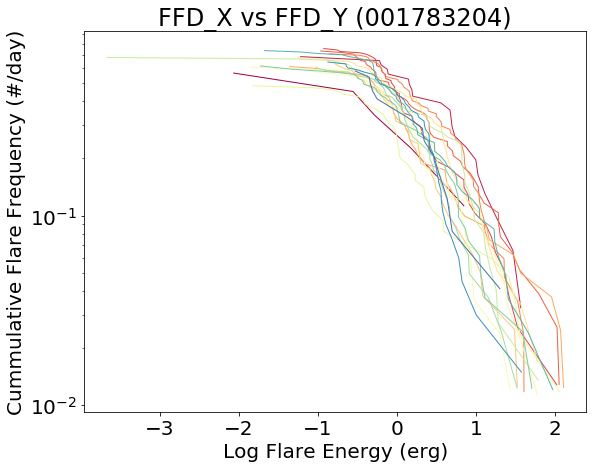

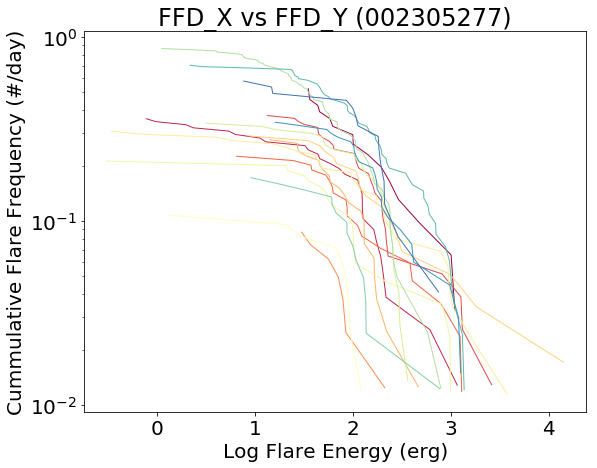

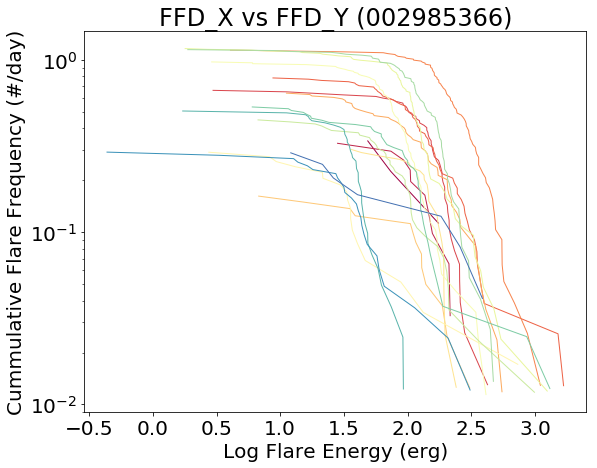

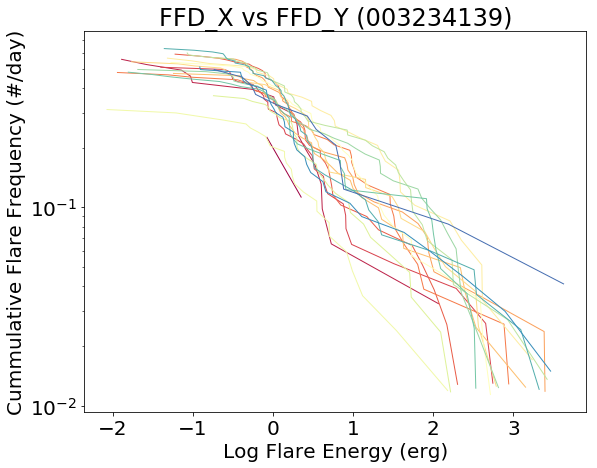

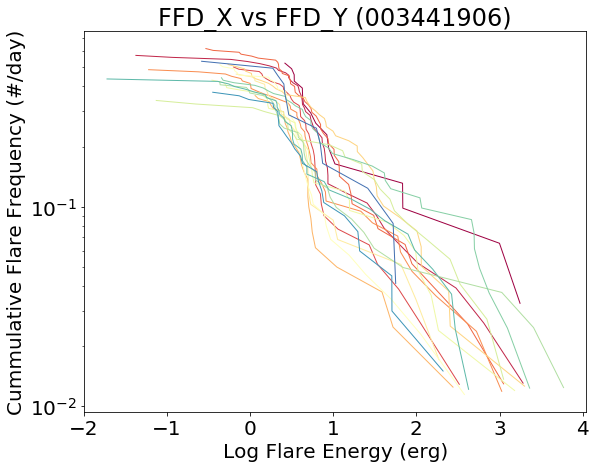

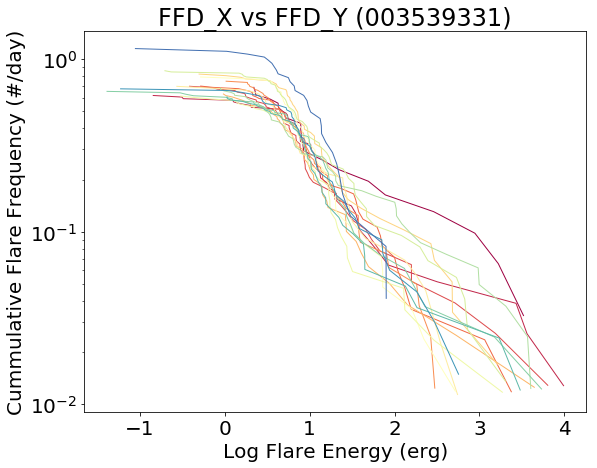

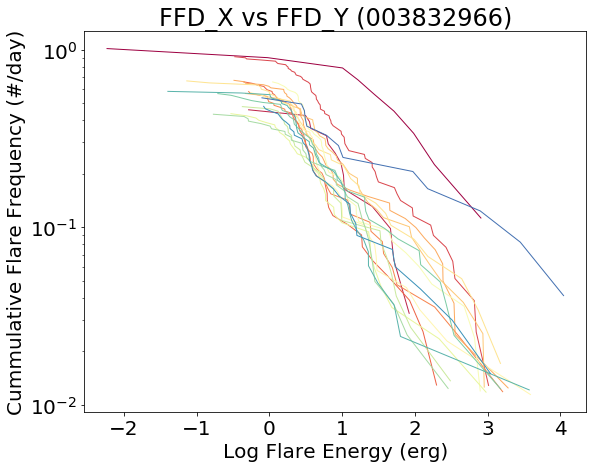

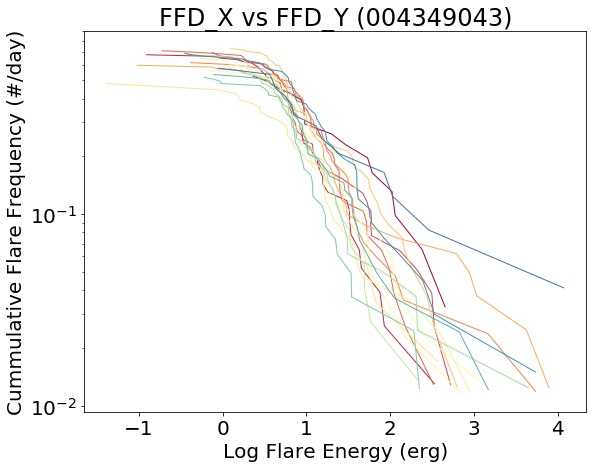

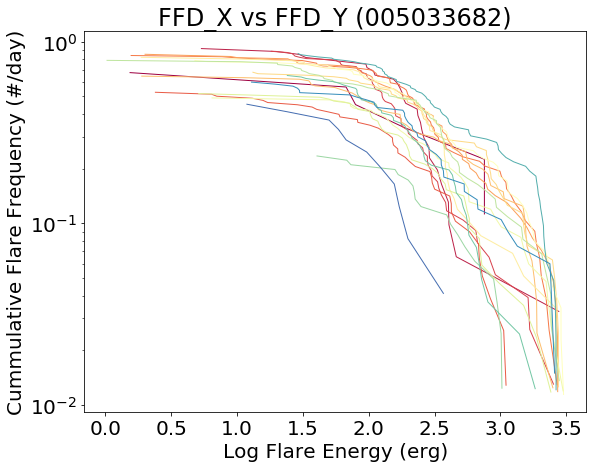

In [16]:
targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    fileCount = len(files)
    
    plotEVF(KIC, files, fileCount, show=True, error=False, whole=True)

# Plotting energy_vs_frequency for just the >ok68 data, and error bars

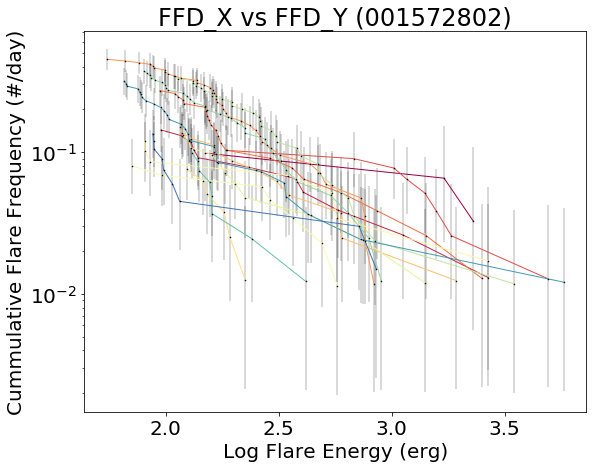

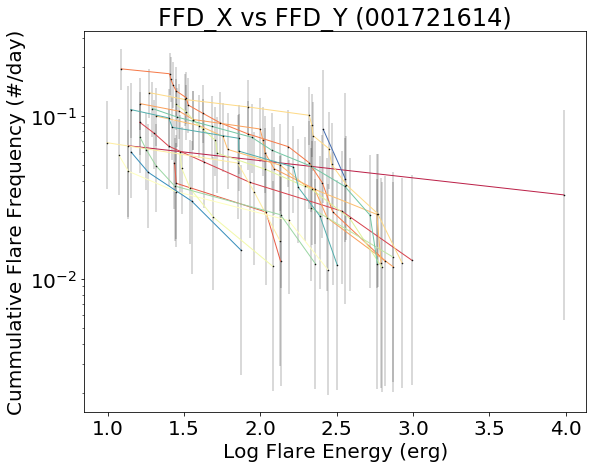

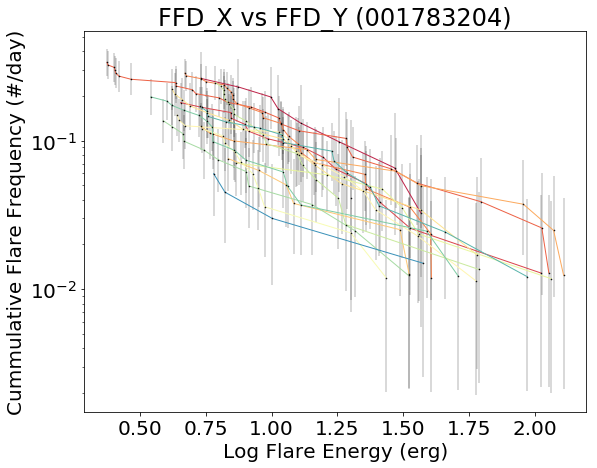

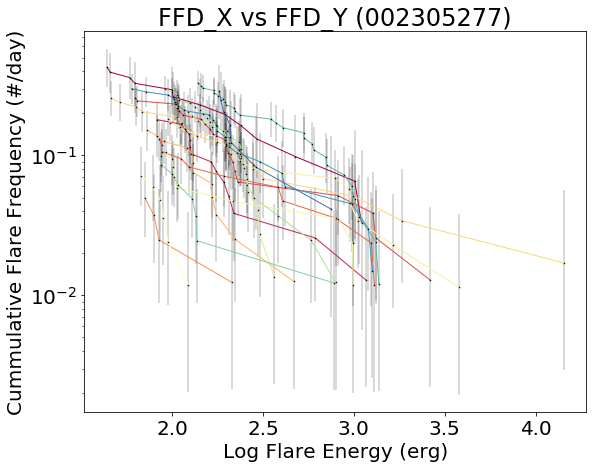

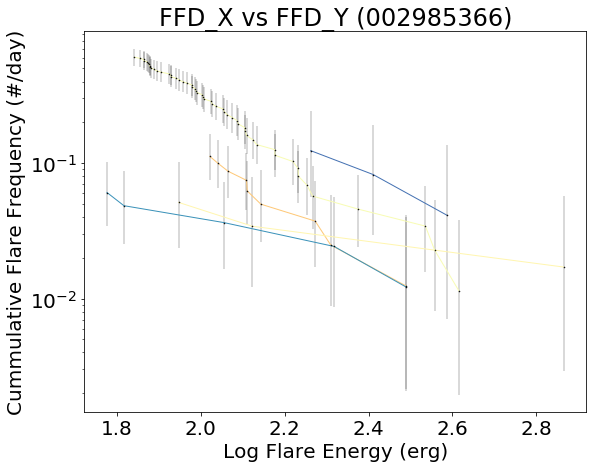

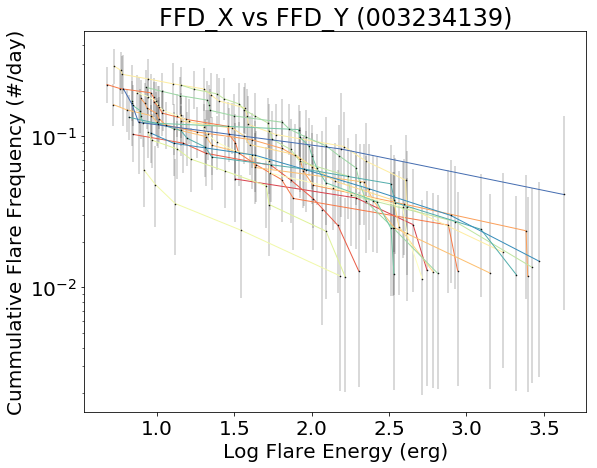

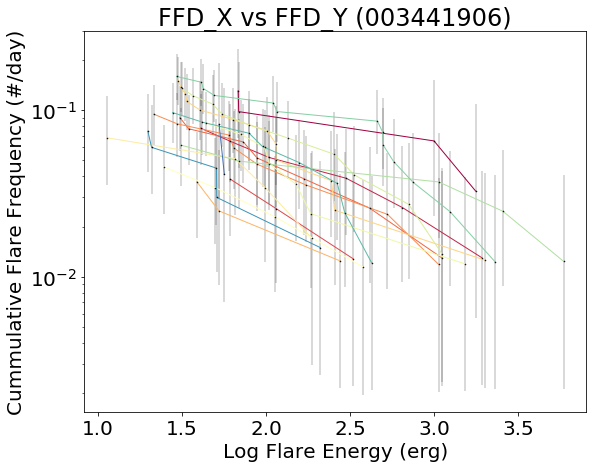

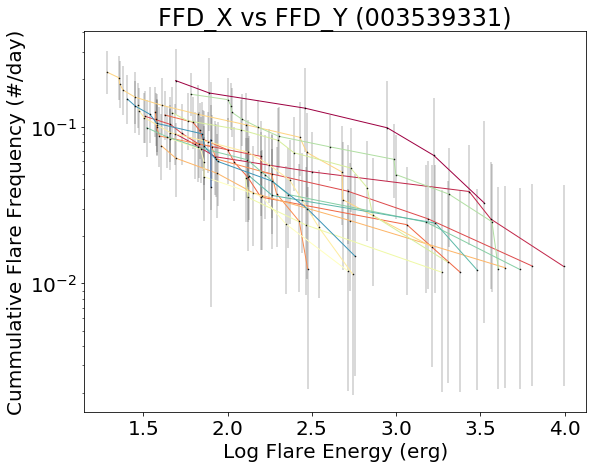

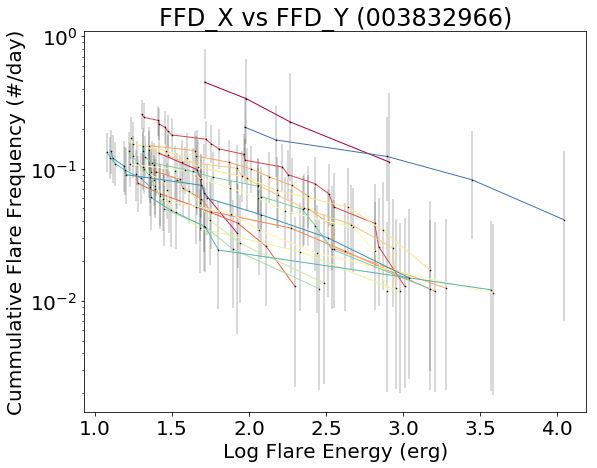

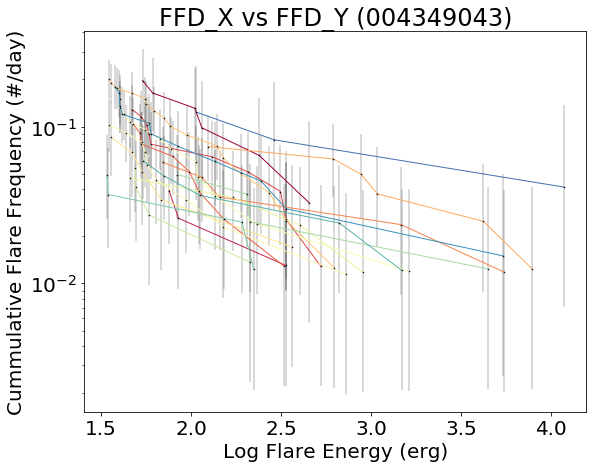

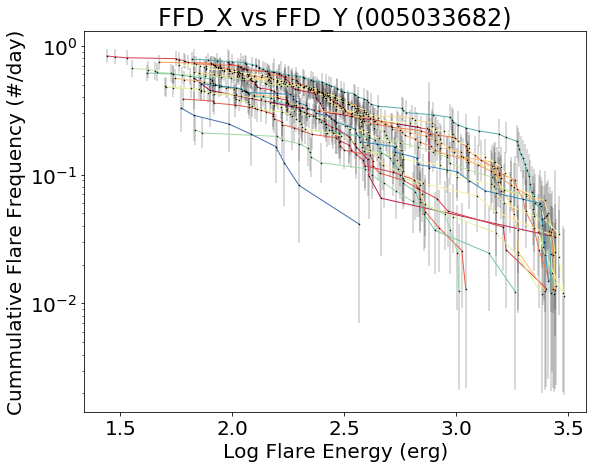

In [17]:
targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    fileCount = len(files)
    
    plotEVF(KIC, files, fileCount, show=True, error=True, whole=False)